# 04 - Pooling, Multilevel, Mixed Effect Models

In [1]:
import sys
import os
from pathlib import Path 

import pandas as pd
import numpy as np
import arviz as az
import pymc3 as pm
import xarray as xr
import theano.tensor as tt
import bambi as bmb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import *
import plotnine as p9

%load_ext dotenv
%dotenv
PROJECT_DIR=Path(os.environ.get('PROJECT_DIR'))
sys.path.append(str(PROJECT_DIR))

from projects.common.berlin_housing.utils.plot_utils import set_plot_defaults, plot_price_area
from projects.common.berlin_housing.utils.data_utils import load_data
from projects.common.berlin_housing.utils.data_utils import destandardize_area, destandardize_price, load_data, standardize_area
from projects.common.berlin_housing.utils.plot_utils import set_plot_defaults, draw_model_plot

DATA_DIR = PROJECT_DIR / 'data'  / 'berlin_housing' / 'interim_data'
DATA_DIR

PosixPath('/media/david/T7/code/bmcp/bmcp-notes/data/berlin_housing/interim_data')

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

theme_set(theme_bw())
pd.set_option('display.max_columns', 100)
xr.set_options(display_expand_data=False, display_expand_attrs=False, display_expand_coords=False,
              display_expand_data_vars=False)
SEED = 1925

%load_ext watermark
%watermark --iversions

theano    : 1.1.2
pymc3     : 3.11.4
seaborn   : 0.11.2
matplotlib: 3.4.3
plotnine  : 0.8.0
numpy     : 1.19.5
pandas    : 1.3.2
xarray    : 0.19.0
arviz     : 0.11.2
sys       : 3.9.7 | packaged by conda-forge | (default, Sep 29 2021, 19:23:11) 
[GCC 9.4.0]
bambi     : 0.6.3



# Data Prep
+ Data cut to rentals < 7,500 pcm to make scatterplots more readable
+ 

In [3]:
df_orig, _, _ = load_data(kind="rents")
df_orig = df_orig[df_orig['rent'] < 7500]
keepers = ['rent', 'zip', 'living_space']
df_orig = df_orig[keepers].reset_index(drop=True)
df_orig['zip'] = df_orig['zip'].astype('category')
df_orig.head()

,rent,zip,living_space
0,941.0,12103,31.00
1,1399.7,14109,82.34
2,830.0,13086,100.59
3,3417.6,10785,213.60
4,490.0,12057,49.00


In [4]:
df_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7244 entries, 0 to 7243
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   rent          7244 non-null   float64 
 1   zip           7244 non-null   category
 2   living_space  7244 non-null   float64 
dtypes: category(1), float64(2)
memory usage: 137.2 KB


# Data Prep

In [5]:
df = df_orig.copy()
zips = df['zip'].value_counts().reset_index().rename(columns={'index': 'zip', 'zip': 'zip_count'})
zip_list = df['zip'].value_counts().index.tolist()
zips.head()

,zip,zip_count
0,10115,206
1,10557,195
2,10117,154
3,12627,143
4,12555,140


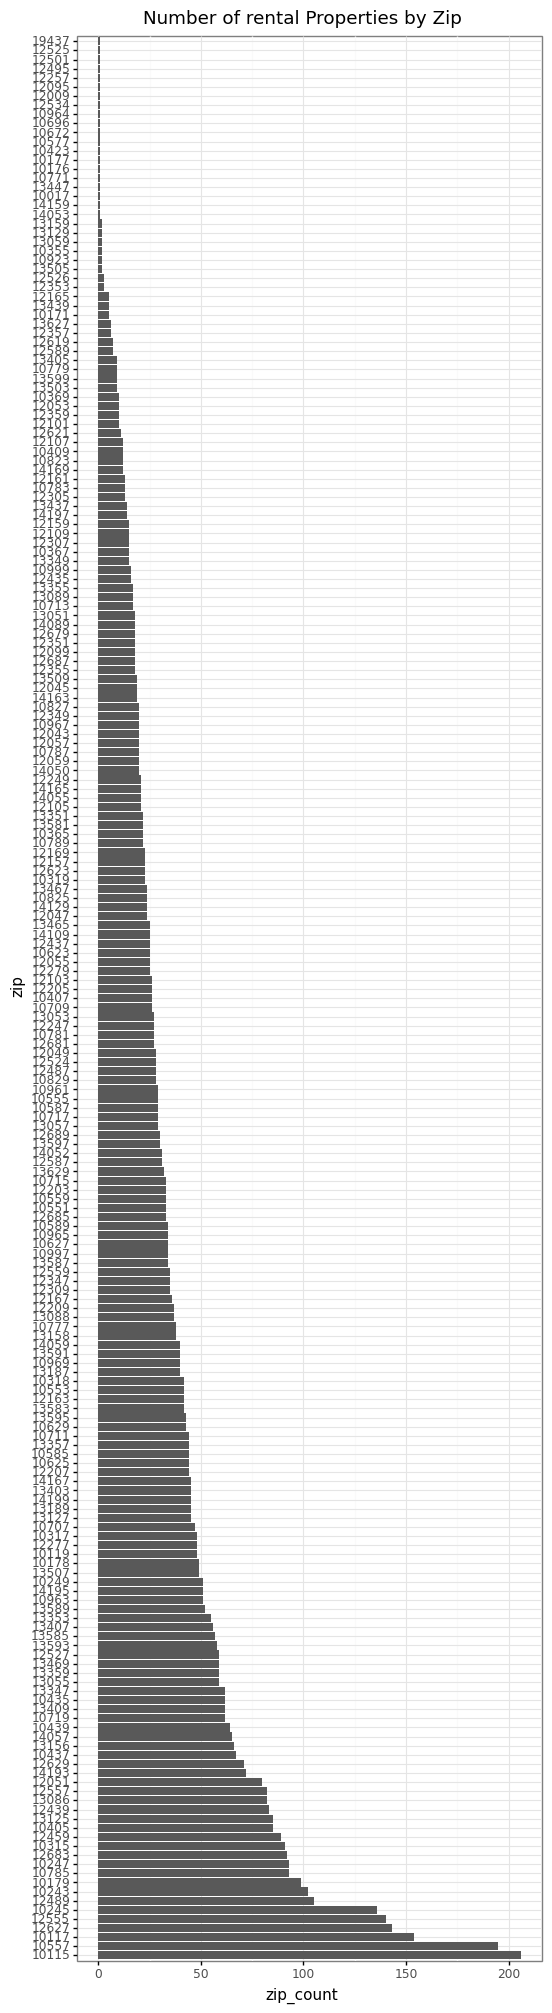

In [6]:
p = (ggplot(zips, aes(x='zip', y='zip_count')) +
     geom_col() +
     theme(figure_size=(6,25)) +
     scale_x_discrete(limits=zip_list) +
     labs(title='Number of rental Properties by Zip') +
     coord_flip()
    )
p.draw();

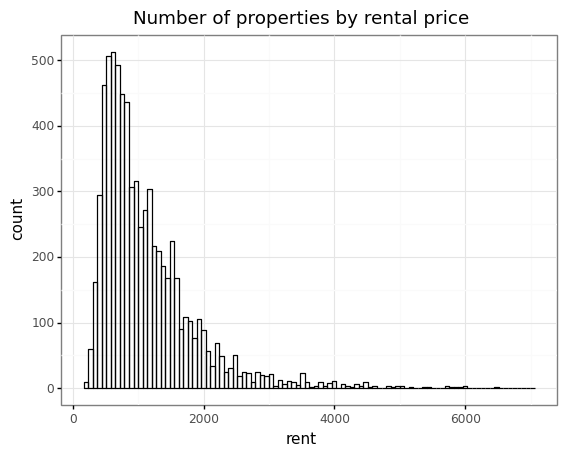

In [7]:
df = df[df['rent'] < 7500]
p = (ggplot(df, aes('rent')) +
     geom_histogram(bins=100, color='black', fill='none') +
     labs(title='Number of properties by rental price') 
    )
p.draw();

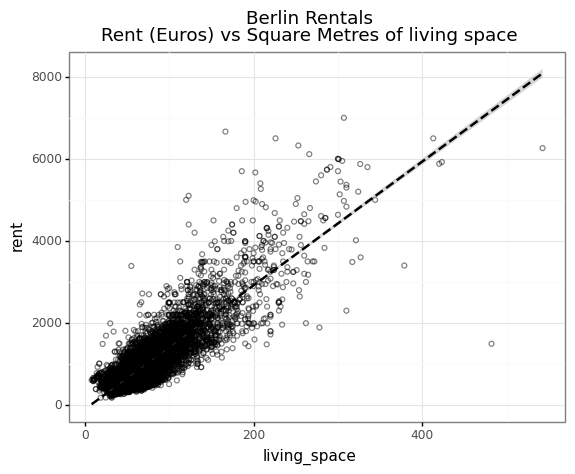

In [8]:
p = (ggplot(df, aes(x='living_space', y='rent'))+
     geom_point(fill='none', color='black', alpha=0.5) +
     geom_smooth(method='lm', linetype='dashed') +
     labs(title='Berlin Rentals\nRent (Euros) vs Square Metres of living space')
    )
p.draw();

/home/david/mambaforge/envs/bmcp/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1650: RuntimeWarning: divide by zero encountered in double_scalars


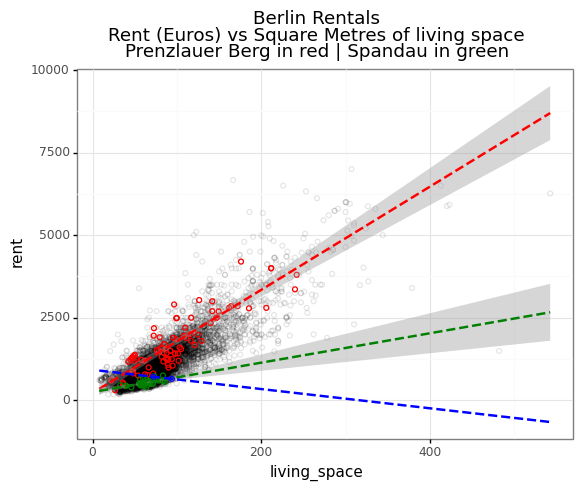

In [9]:
p = (ggplot(df, aes(x='living_space', y='rent'))+
     geom_point(fill='none', color='black', alpha=0.1) +
     geom_point(df[df['zip']=='10405'], aes(x='living_space', y='rent'), color='red', fill='none') +
     geom_smooth(df[df['zip']=='10405'], method='lm', color='red', linetype='dashed', fullrange=True) +
     geom_point(df[df['zip']=='13583'], aes(x='living_space', y='rent'), color='green', fill='none') +
     geom_smooth(df[df['zip']=='13583'], method='lm', color='green', linetype='dashed', fullrange=True) +
     geom_point(df[df['zip']=='13129'], aes(x='living_space', y='rent'), color='blue', fill='none') +
     geom_smooth(df[df['zip']=='13129'], method='lm', color='blue', linetype='dashed', fullrange=True) +
     labs(title='Berlin Rentals\nRent (Euros) vs Square Metres of living space\nPrenzlauer Berg in red | Spandau in green')
    )
p.draw();

/home/david/mambaforge/envs/bmcp/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1650: RuntimeWarning: divide by zero encountered in double_scalars


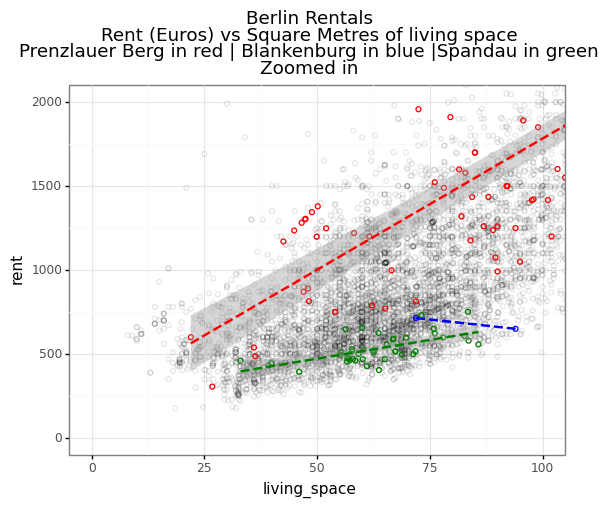

In [10]:
p = (ggplot(df, aes(x='living_space', y='rent'))+
     geom_point(fill='none', color='black', alpha=0.1) +
     geom_point(df[df['zip']=='13129'], aes(x='living_space', y='rent'), color='blue', fill='none') +
     geom_smooth(df[df['zip']=='13129'], method='lm', color='blue', linetype='dashed', fullrange=False) +
     geom_point(df[df['zip']=='10405'], aes(x='living_space', y='rent'), color='red', fill='none') +
     geom_smooth(df[df['zip']=='10405'], method='lm', color='red', linetype='dashed', fullrange=False) +
     geom_point(df[df['zip']=='13583'], aes(x='living_space', y='rent'), color='green', fill='none') +
     geom_smooth(df[df['zip']=='13583'], method='lm', color='green', linetype='dashed', fullrange=False) +
     coord_cartesian(xlim=(0, 100), ylim=(0, 2000)) +
     labs(title='Berlin Rentals\nRent (Euros) vs Square Metres of living space\nPrenzlauer Berg in red | Blankenburg in blue |Spandau in green\nZoomed in')
    )
p.draw();

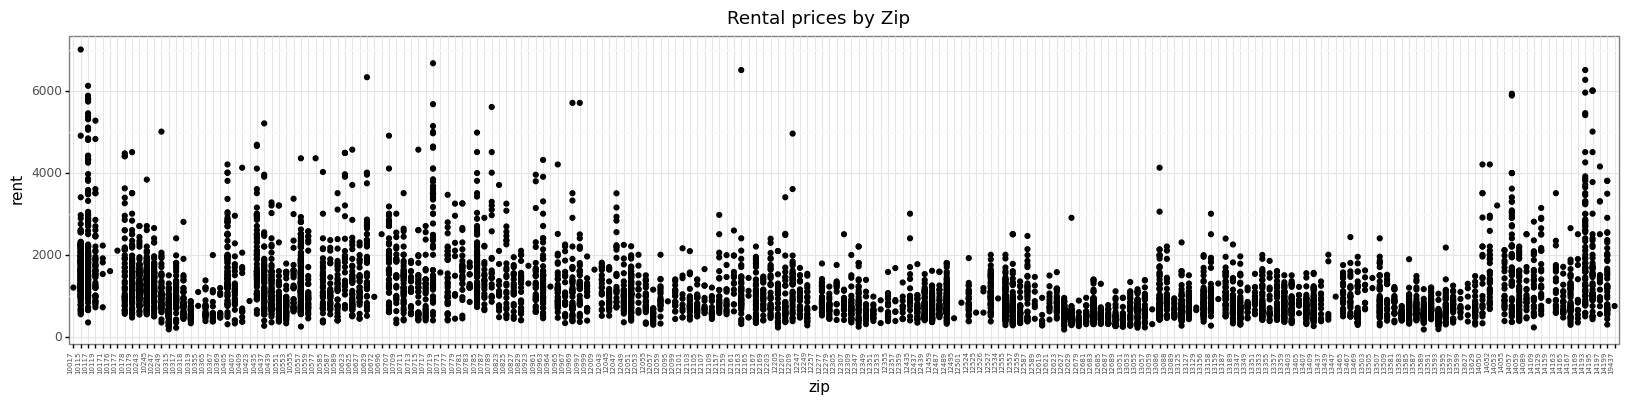

In [11]:
df = df_orig.copy()
p = (ggplot(df, aes(x='zip', y='rent')) +
     geom_point() +
     theme(figure_size=(20, 4)) +
     theme(axis_text_x = element_text(angle = 90, hjust=1, size=5)) +
     labs(title='Rental prices by Zip')
    )
p.draw();


In [12]:
df

,rent,zip,living_space
0,941.00,12103,31.00
1,1399.70,14109,82.34
2,830.00,13086,100.59
3,3417.60,10785,213.60
4,490.00,12057,49.00
...,...,...,...
7239,1170.00,10997,63.36
7240,378.95,10367,34.45
7241,579.00,12559,60.00
7242,1748.00,10557,95.00


## Comments
+ As a general trend rental price increases as living space (square metres) increases
+ ~ 20 zip codes have only one rent price - cannot model a linear relationship with just one point
+ Plenty of zip codes with 2,3, or 4 points. This is a small sample size, so modeling will most likely not be reliable - See Blankenburg above.
+ Clearly Spandau has a different regression slope to Prenzlauer Berg, and both will most likely have a different regression line to the full dataset.
+ Modeling Options
    + Unpooled parameters

# Data Preparation

In [13]:
def prep_data(df_orig):
    df = df_orig.copy()
    # Cut back dataset to target and 2 variables
    keepers1 = ['rent', 'living_space', 'zip']
    keepers2 = ['rent_scaled', 'living_space_ctrd', 'zip']
    # Cleanup zip column and make codes
    df['zip'] = df['zip'].astype('str').str.strip().astype('category')
    df['zip_coded'] = df['zip'].cat.codes
    df['zip_coded'] = df['zip_coded'].astype('category')
    # Centre living space
    df['living_space_ctrd'] = df['living_space'] - df['living_space'].mean()
    # Scale the rent to 1000s
    df['rent_scaled'] = df['rent']/10
    return df.reset_index(drop=True)

dfm = prep_data(df_orig)
dfm1 = dfm.copy()[['rent_scaled', 'living_space_ctrd', 'zip_coded']]
dfm1.head()

,rent_scaled,living_space_ctrd,zip_coded
0,94.10,-50.864215,84
1,139.97,0.475785,199
2,83.00,18.725785,148
3,341.76,131.735785,55
4,49.00,-32.864215,79


In [14]:
n_zips = len(dfm1['zip_coded'].cat.categories)
n_zips

211

In [15]:
zip_coded = dfm['zip_coded'].values
zip_coded

[84, 199, 148, 55, 79, ..., 69, 19, 129, 31, 93]
Length: 7244
Categories (211, int64): [0, 1, 2, 3, ..., 207, 208, 209, 210]

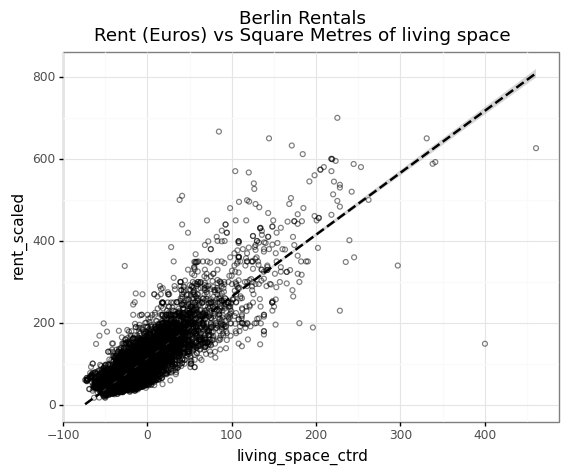

In [16]:
p = (ggplot(dfm1, aes(x='living_space_ctrd', y='rent_scaled'))+
     geom_point(fill='none', color='black', alpha=0.5) +
     geom_smooth(method='lm', linetype='dashed') +
     labs(title='Berlin Rentals\nRent (Euros) vs Square Metres of living space')
    )
p.draw();

## TODO - Notes on Prior Selection

# Pooled Parameters

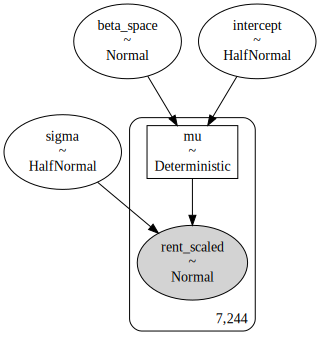

In [17]:
with pm.Model() as rent_model_pooled:
    
    sigma = pm.HalfNormal('sigma', 100)
    
    intercept = pm.HalfNormal('intercept', 150.0)
    beta_space = pm.Normal('beta_space', mu=1, sigma=1)
        
    mu = pm.Deterministic('mu', intercept + beta_space*dfm1['living_space_ctrd'].values)
    
    rent = pm.Normal('rent_scaled', mu=mu, sigma=sigma, observed=dfm1['rent_scaled'].values)
    
    prior_pred = pm.sample_prior_predictive()
    idata_pooled = az.from_pymc3(prior=prior_pred)

pm.model_to_graphviz(rent_model_pooled)

In [18]:
idata_pooled

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data

In [19]:
# dfm1

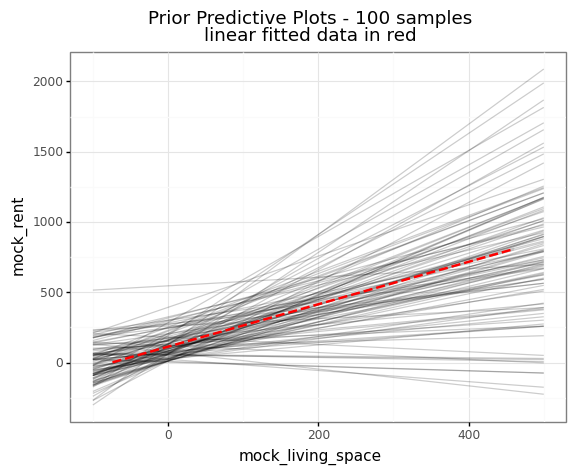

In [20]:
n_samples = 100

prior_df = idata_pooled.prior[['intercept', 'beta_space']].to_dataframe().droplevel(0)

mock_living_space = np.linspace(-100, 500, 26)
line_dfs = []
for idx, row in prior_df.sample(n_samples).iterrows():
    mock_rent = row.intercept + row.beta_space*mock_living_space
    line_df = pd.DataFrame({'mock_rent': mock_rent, 'mock_living_space': mock_living_space}).assign(idx=idx)
    line_dfs.append(line_df)
prior_mock_df = pd.concat(line_dfs, axis=0)

p = (ggplot(prior_mock_df, aes(x='mock_living_space', y='mock_rent', group='idx')) +
     geom_line(alpha=0.2) +
     geom_smooth(dfm1, aes(x='living_space_ctrd', y='rent_scaled'), method='lm', linetype='dashed', color='red') +
     labs(title=f'Prior Predictive Plots - {n_samples} samples\nlinear fitted data in red')
    )
p.draw();

In [21]:
with rent_model_pooled:
    trace = pm.sample()
    idata_pooled.extend(az.from_pymc3(trace=trace))

/tmp/ipykernel_3128038/1014436265.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_space, intercept, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [22]:
idata_pooled

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data
	> posterior
	> log_likelihood
	> sample_stats

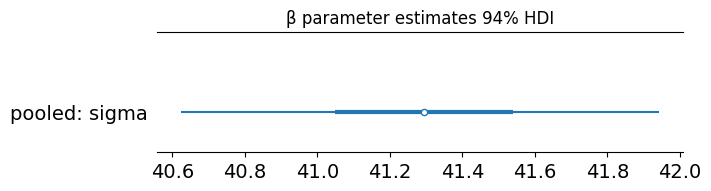

In [23]:
axes = az.plot_forest([idata_pooled],
                      model_names = ["pooled",],
                      var_names=["sigma"], combined=True, figsize=(7, 1.8));
axes[0].set_title("β parameter estimates 94% HDI")
plt.show();

# Unpooled Parameters

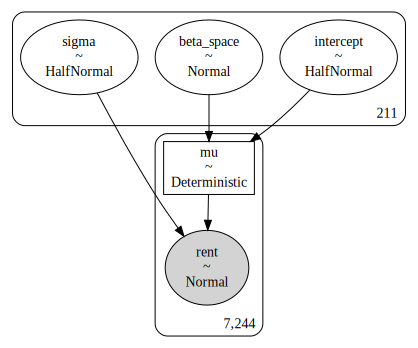

In [24]:
with pm.Model() as rent_model_unpooled:
    sigma = pm.HalfNormal('sigma', 100, shape=n_zips)
    
    intercept = pm.HalfNormal('intercept', 150, shape=n_zips)
    beta_space = pm.Normal('beta_space', mu=1, sigma=1, shape=n_zips)
    
    mu = pm.Deterministic('mu', intercept[zip_coded] + beta_space[zip_coded]*dfm['living_space_ctrd'].values)
    
    rent = pm.Normal('rent', mu=mu, sigma=sigma[zip_coded], observed=dfm1['rent_scaled'].values)
    
    prior_pred = pm.sample_prior_predictive()
    idata_unpooled = az.from_pymc3(prior=prior_pred)

pm.model_to_graphviz(rent_model_unpooled)

In [25]:
with rent_model_unpooled:
    trace = pm.sample()
    idata_unpooled.extend(az.from_pymc3(trace=trace))

/tmp/ipykernel_3128038/4246366756.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_space, intercept, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 53 seconds.
There were 834 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.332150362670166, but should be close to 0.8. Try to increase the number of tuning steps.
There were 681 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5315228891654162, but should be close to 0.8. Try to increase the number of tuning steps.
There were 830 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4691321896548864, but should be close to 0.8. Try to increase the number of tuning steps.
There were 533 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimate

In [26]:
idata_unpooled

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data
	> posterior
	> log_likelihood
	> sample_stats

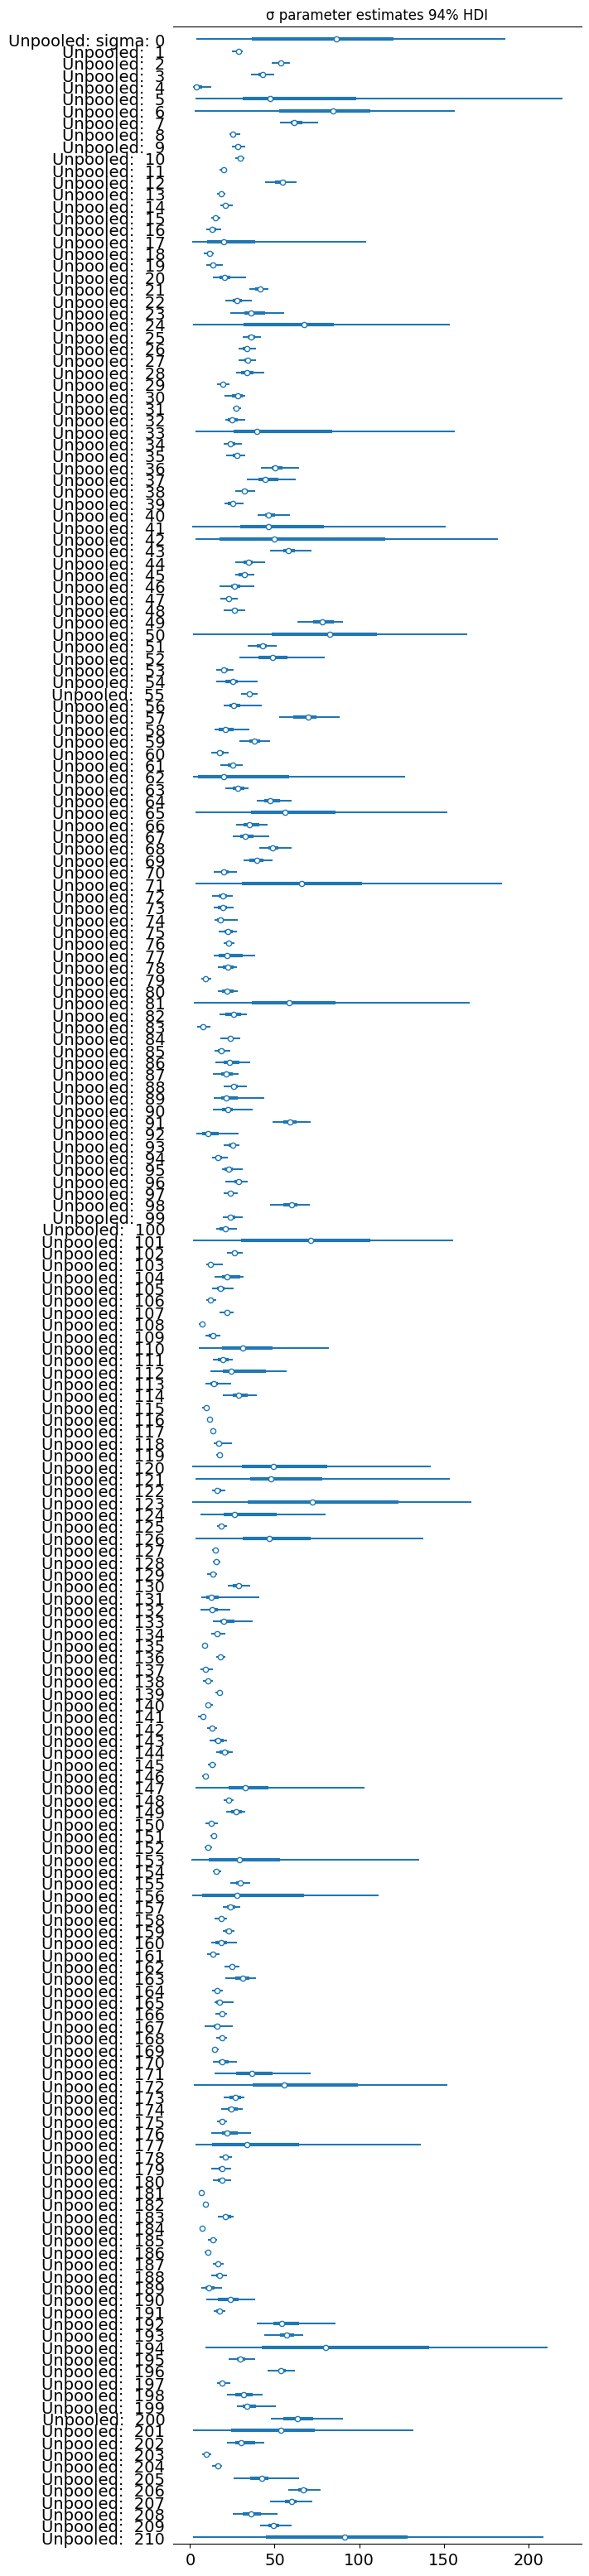

In [27]:
axes = az.plot_forest([idata_unpooled,],
                      model_names = ["Unpooled",],
                      var_names=["sigma"], combined=True, figsize=(7, 31));
axes[0].set_title("σ parameter estimates 94% HDI")
plt.show();

In [28]:
dfm[dfm['zip_coded']==210].head()

,rent,zip,living_space,zip_coded,living_space_ctrd,rent_scaled
5318,750.0,19437,48.0,210,-33.864215,75.0


In [29]:
x = dfm[dfm['zip_coded']==209]
print(len(x))
x.head()

45


,rent,zip,living_space,zip_coded,living_space_ctrd,rent_scaled
133,1006.12,14199,133.71,209,51.845785,100.612
160,1198.50,14199,85.60,209,3.735785,119.850
325,1420.00,14199,95.00,209,13.135785,142.000
565,1550.00,14199,85.00,209,3.135785,155.000
747,300.00,14199,32.00,209,-49.864215,30.000


In [30]:
x = dfm[dfm['zip_coded']==208]
print(len(x))
x.head()

14


,rent,zip,living_space,zip_coded,living_space_ctrd,rent_scaled
620,557.11,14197,79.36,208,-2.504215,55.711
1327,2500.00,14197,157.00,208,75.135785,250.000
1864,3300.00,14197,217.57,208,135.705785,330.000
2183,1150.00,14197,91.88,208,10.015785,115.000
3259,1325.00,14197,103.00,208,21.135785,132.500


In [31]:
# Diagnosis
# az.plot_khat(idata_unpooled, xlabels=True, threshold=1)
# plt.show();

# khats = loo_idata_unpooled.pareto_k.to_dataframe()
# n = 100
# top_n_high_khats = khats.sort_values(by=['pareto_shape']).tail(n)
# top_n_high_khats.tail(5)

# train = pd.concat([X_train, y_train], axis=1)
# train_top_n_high_khats = train.iloc[top_n_high_khats.index]
# train_top_n_high_khats

# p = (ggplot(train, aes(x='living_space_ctrd', y='rent_scaled'))+
#      geom_point(fill='none', color='black', alpha=0.5) +
#      geom_point(train_top_n_high_khats, color='red') +
#      labs(title='Berlin Rentals\nRent (Euros) vs Square Metres of living space')
#     )
# p.draw();

# Mixing Group and Common Parameters
+ sigma - common across zip codes
+ intercept - changes by zip code - ie step change between zips
+ beta_space - rate of change common across zip codes

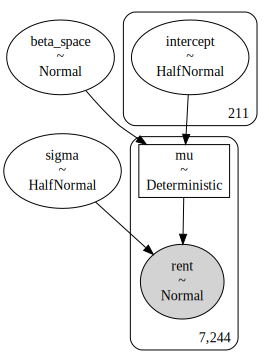

In [32]:
with pm.Model() as rent_model_pooled_sigmabeta:
    sigma = pm.HalfNormal('sigma', 100)
    
    intercept = pm.HalfNormal('intercept', 150, shape=n_zips)
    beta_space = pm.Normal('beta_space', mu=1, sigma=1)
    
    mu = pm.Deterministic('mu', intercept[zip_coded] + beta_space*dfm['living_space_ctrd'].values)
    
    rent = pm.Normal('rent', mu=mu, sigma=sigma, observed=dfm1['rent_scaled'].values)
    
    prior_pred = pm.sample_prior_predictive()
    idata_pooled_sigmabeta = az.from_pymc3(prior=prior_pred)

pm.model_to_graphviz(rent_model_pooled_sigmabeta)

In [33]:
with rent_model_pooled_sigmabeta:
    trace = pm.sample()
    idata_pooled_sigmabeta.extend(az.from_pymc3(trace=trace))

/tmp/ipykernel_3128038/3451617404.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_space, intercept, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.


In [34]:
idata_pooled_sigmabeta

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data
	> posterior
	> log_likelihood
	> sample_stats

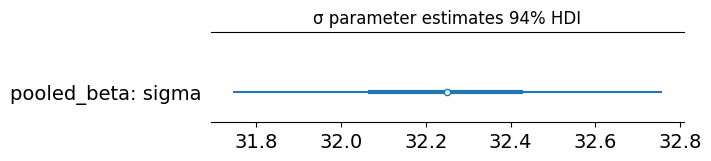

In [35]:
axes = az.plot_forest([idata_pooled_sigmabeta,],
                      model_names = ["pooled_beta",],
                      var_names=["sigma"], combined=True, figsize=(7, 1.5));
axes[0].set_title("σ parameter estimates 94% HDI")
# plt.savefig("img/chp04/salad_sales_basic_regression_forestplot_sigma.png")
plt.show();

In [36]:
# TODO loo score comparison